# [Parallel computing](https://en.wikipedia.org/wiki/Parallel_computing)

## Définitions

### Processus

Un processus est une instance d'un programme en cours d'exécution. Il
contient le code du programme, **ses données actuelles**, et son état
d'exécution. Les processus sont indépendants et peuvent être exécutés simultanément sur différents cœurs de processeur.

Exemple:

* Notre système de tache
* Les crons

> Si on souhaite faire communiquer des processus, on peut utiliser des IPC (Inter Process Communication)
> comme par exemple dans notre cas RabbitMQ

### Thread

Un thread est une unité plus petite d'exécution au sein d'un processus. Les
threads partagent le **même espace mémoire et les ressources** du processus
parent, ce qui permet une communication plus rapide et une utilisation plus efficace des ressources. Les threads sont souvent utilisés pour des tâches qui nécessitent une exécution simultanée au sein du même programme.

Exemples:

* Handling des requêtes HTTP

![web_server_threads](../resources/web_server_threads.png)

## Parallelisation des calculs

![single_thread](../resources/Single_thread_execution.png)

On pourrait aussi utiliser des threads pour paralléliser les calculs

![multi_thread](../resources/multiple_threads.png)

## Répartition des taches

Lorsqu'on est amené à faire de l'IO (requête API par exemple), il peut y avoir des bloquages d'IO.

Les taches n'ont pas toutes la même durée.

![single_thread_task_different_time](../resources/single_thread_task_different_time.png)

In [10]:
import os

API_URL: str = os.getenv("API_URL")

In [11]:
import requests
from time import time
from typing import List

start_time: time = time()
for meter_id in range(200):
    r = requests.get(f"{API_URL}/meter/{meter_id}/conso")
end_time: time = time()
single_thread_total_time = end_time - start_time
single_thread_total_time

12.410677433013916

Si on réparti mal les taches, on risque de se retrouver avec un thread qui ne fait rien pendant que les autres ont plus de charge de travail

![multiple_threads_task_different_time](../resources/bad_task_repartition.png)

Pour éviter ce genre de problèmes, on peut mettre en place une *thread pool*

Dans le cas d'une thread pool, on ne réparti pas manuellement les taches entre les threads. Les threads viennent prendre une tache à faire lorsqu'ils n'ont rien à faire.

![task_queue](../resources/task_queue.png)

![thread_pool_1](../resources/thread_pool_1.png)

![thread_pool_2](../resources/thread_pool_2.png)


https://docs.python.org/3.11/library/concurrent.futures.html#threadpoolexecutor

In [21]:
from concurrent.futures import ThreadPoolExecutor, as_completed

with ThreadPoolExecutor() as executor:
    start_time: time = time()
    future_responses = [executor.submit(requests.get, f"{API_URL}/meter/{meter_id}/conso") for meter_id in range(200)]
    for _ in as_completed(future_responses):
        pass
    end_time: time = time()
    thread_pool_total_time = end_time - start_time
thread_pool_total_time

1.0454092025756836

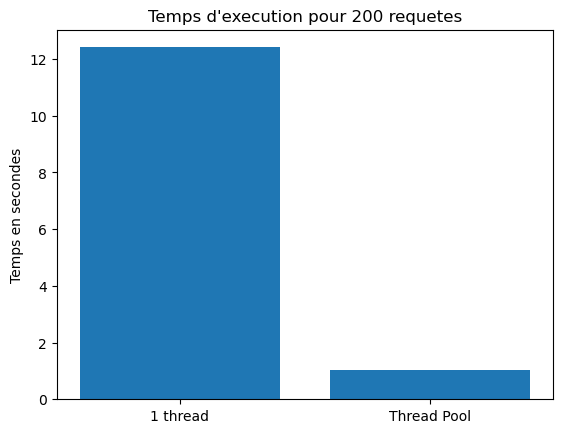

In [22]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()

ax.bar(["1 thread", "Thread Pool"], [single_thread_total_time, thread_pool_total_time])
ax.set_ylabel("Temps en secondes")
ax.set_title("Temps d'execution pour 200 requetes")

plt.show()

## Pour aller plus loin

### Programmation GPU

![GPU](../resources/architecture_gpu_cpu.png)

Efficace pour les petites opérations a faire en simultané.

Ex: calculs matriciels

#### [CUDA](https://developer.nvidia.com/cuda-toolkit)

```cpp
// Kernel definition
__global__ void VecAdd(float* A, float* B, float* C)
{
    int i = threadIdx.x;
    C[i] = A[i] + B[i];
}

int main()
{
    ...
    // Kernel invocation with N threads
    VecAdd<<<1, N>>>(A, B, C);
    ...
}
```

#### [Lib Thrust(C++)](https://developer.nvidia.com/thrust)

Pour faire court, la STL portée sur GPU

> Possibilité d'expérimenter la programmation GPU avec [Google Colab](https://colab.research.google.com/)

### [Mojo](https://www.modular.com/mojo)

Un mix entre le python et le rust.

Un langage pensé pour faire de l'IA et des calculs de matrices.